In [1]:
#Importing all the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from pydub import AudioSegment
import librosa
import librosa.display
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from keras import Sequential
from tensorflow.keras.layers import LSTM, Dense
import IPython.display as ipd
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Lambda

In [2]:
# Function to compute Levenshtein distance between 2 passages
def levenshtein_distance(s1, s2):
    if len(s1) < len(s2):
        return levenshtein_distance(s2, s1)

    if len(s2) == 0:
        return len(s1)

    previous_row = range(len(s2) + 1)
    for i, c1 in enumerate(s1):
        current_row = [i + 1]
        for j, c2 in enumerate(s2):
            insertions = previous_row[j + 1] + 1
            deletions = current_row[j] + 1
            substitutions = previous_row[j] + (c1 != c2)
            current_row.append(min(insertions, deletions, substitutions))
        previous_row = current_row

    return previous_row[-1]

# creating new path for adjusted recordings (both speechkits' and tolokers')
def create_new_path(file_path):
    parts = file_path.rsplit('.', 1)
    return f"{parts[0]}-new.{parts[1]}"

In [3]:
# Dictionary with all 10 texts that tolokers were required to record
text_dict = {
1 : "When she was a child Jennifer liked sports and she played hockey and basketball for an all-boys team. She also worked as a model. At the age of 14 she knew she wanted to be an actress, so she went to New York City to look for work. She appeared in advertisements for MTV and the fashion company Zara and got work as an actress on TV. Her family moved to Los Angeles so that Jennifer could work on TV and in films.",
2 : "Monday is viewed by many to be the worst day of the week, as it marks the return to work following the weekend, when most full-time employees are given two days off. Most students attend school in the morning and return home in the afternoon (usually from about eight until three or seven until two), and most workers go to work in the morning and return home in the evening (usually from nine to five or eight to four).",
3 : "London is a famous and historic city. It is the capital of England in the United Kingdom. The city is quite popular for international tourism because London is home to one of the oldest-standing monarchies in the western area. Rita and Joanne recently travelled to London. They were very excited for their trip because this was their first journey overseas from the United States.",
4 : "I am living with a very welcoming host family. I have my own private bedroom, but we eat breakfast, lunch, and dinner together. On Sundays, we eat a big home-cooked soup for lunch. In Spain, lunch is usually the biggest meal of the day. It's also very common for people to take a midday nap right after a big meal. I am actually just waking up from my nap right now!",
5 : "My name is Bob. Each day I drive my kids to school. My daughter goes to a school that’s far from our house. It takes 30 minutes to get there. Then I drive my son to his school. It’s close to my job. My daughter is in the sixth grade and my son is in the second. They are both good students. My daughter usually sings her favourite songs while I drive. My son usually sleeps.",
6 : "A red and yellow flag tells you to swim between the flags. They show the supervised area of the beach. This means that lifeguards are watching that area. If there are no red and yellow flags it means there is no supervision. Check with the lifeguards and if you are unsure do not go into the water. Black and white check flag shows where board riding and surfing is not allowed.",
7 : "Lucas goes to school every day of the week. He has many subjects to go to each school day: English, art, science, mathematics, gym, and history. His mother packs a big backpack full of books and lunch for Lucas. His first class is English, and he likes that teacher very much. His English teacher says that he is a good pupil, which Lucas knows means that she thinks he is a good student.",
8 : "You can also take one small laptop bag or handbag that can fit under the seat in front of you. If you have two bags, their total weight cannot be more than the limit. If your bag is too big or too heavy, you will not be allowed to take it onto the plane. Staff will put it in the hold for you and you will have to pay extra. Please make sure mobile phones and other devices are fully-charged so security staff can check them.",
9 : "I live in an apartment. In my city, there is a post office where people mail letters. On Monday, I go to work. I work at the post office. Everyone shops for food at the grocery store. They also eat at the restaurant. The restaurant serves pizza and ice cream. My friends and I often go to the park. We like to play soccer at the park. On Fridays, we go to the cinema to see a movie.",
10 : "Chocolates and flowers are commonly given as gifts during Valentine's Day, as are accompanying greeting cards. Red and pink are generally understood to be the colours of Valentine's Day, and many individuals, instead of celebrating romantically, spend the holiday with their friends or family members."
  }

In [4]:
# Reading the prepared dataset after text transcription with the help of Yandex Speechkit Library, 
# removing observations  with NaN in the column 'transcribed_text'
texts_uncleaned = pd.read_csv("prepared_data.csv")
texts = texts_uncleaned.dropna(subset=['transcribed_text'])
# r_text = texts_uncleaned[texts_uncleaned['INPUT:audio'] == 'https://storage.yandexcloud.net/toloka-chebotarev/TextR_1.0.wav']

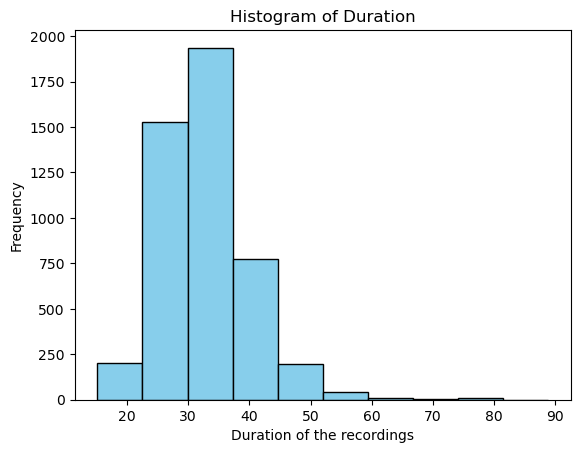

In [5]:
# Plotting histogram of duration
plt.hist(texts['duration'], bins=10, color='skyblue', edgecolor='black')
plt.xlabel('Duration of the recordings')
plt.ylabel('Frequency')
plt.title('Histogram of Duration')

# Display the plot
plt.show()


In [6]:
# Computing Levenshtein distance and adding it as feature in our dataset
for index, row in texts.iterrows():
    try:
        texts.at[index, 'levenshtein_distance'] = levenshtein_distance(row['transcribed_text'], text_dict[row['assigned_text']])
    except TypeError:
        print(index)

/var/folders/19/c1p_mvln6fx6yqh1573217q00000gn/T/ipykernel_97535/1026159099.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  texts.at[index, 'levenshtein_distance'] = levenshtein_distance(row['transcribed_text'], text_dict[row['assigned_text']])


In [7]:
#Dropping irrelevant columns (index repetition)
texts.drop(['Unnamed: 0.1', 'Unnamed: 0'], axis = 1, inplace = True)
texts.head(3)

/var/folders/19/c1p_mvln6fx6yqh1573217q00000gn/T/ipykernel_97535/2710462381.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  texts.drop(['Unnamed: 0.1', 'Unnamed: 0'], axis = 1, inplace = True)


,INPUT:audio,INPUT:image,OUTPUT:recording,OUTPUT:result_3d_question,OUTPUT:result_1st_question,OUTPUT:result_2nd_question,OUTPUT:result_4th_question,ASSIGNMENT:assignment_id,ASSIGNMENT:worker_id,speechkit_path,file_path,duration,new_path,new_speechkit_path,assigned_text,transcribed_text,levenshtein_distance
0,https://storage.yandexcloud.net/toloka-chebota...,https://storage.yandexcloud.net/toloka-chebota...,eu.7cc55f72-618c-4ac6-ae75-d9a27bdec249,No,No,No,No,00028edf7c--6613eacdecfe467e31a1b8cb,b2c2c06f6bf8eed800e25881029fbcf7,/Users/grigorijcebotarev/Desktop/thesis/Record...,/Users/grigorijcebotarev/Desktop/thesis/Record...,66.72,/Users/grigorijcebotarev/Desktop/thesis/Record...,/Users/grigorijcebotarev/Desktop/thesis/Record...,1,When she was a child jennifer jennifer liked s...,99.0
1,https://storage.yandexcloud.net/toloka-chebota...,https://storage.yandexcloud.net/toloka-chebota...,eu.c334a2ee-536d-43a3-8f67-972fb9d50d7a,Yes,Yes,No,No,00028edf7c--6613ead849336b29782c831c,6a77f4ba1d04551c0c776dbd7b38e2f5,/Users/grigorijcebotarev/Desktop/thesis/Record...,/Users/grigorijcebotarev/Desktop/thesis/Record...,36.88,/Users/grigorijcebotarev/Desktop/thesis/Record...,/Users/grigorijcebotarev/Desktop/thesis/Record...,3,London is a famous and if her historical city ...,88.0
2,https://storage.yandexcloud.net/toloka-chebota...,https://storage.yandexcloud.net/toloka-chebota...,eu.7e09aeb4-fa43-4c93-9434-983c2cf8495b,No,No,No,No,00028edf7c--6613eaf349336b29782c8615,6e9fdeeb3d0dfb1afd888aa5c8d347e6,/Users/grigorijcebotarev/Desktop/thesis/Record...,/Users/grigorijcebotarev/Desktop/thesis/Record...,24.54,/Users/grigorijcebotarev/Desktop/thesis/Record...,/Users/grigorijcebotarev/Desktop/thesis/Record...,3,London is a famous and historic city it is the...,28.0


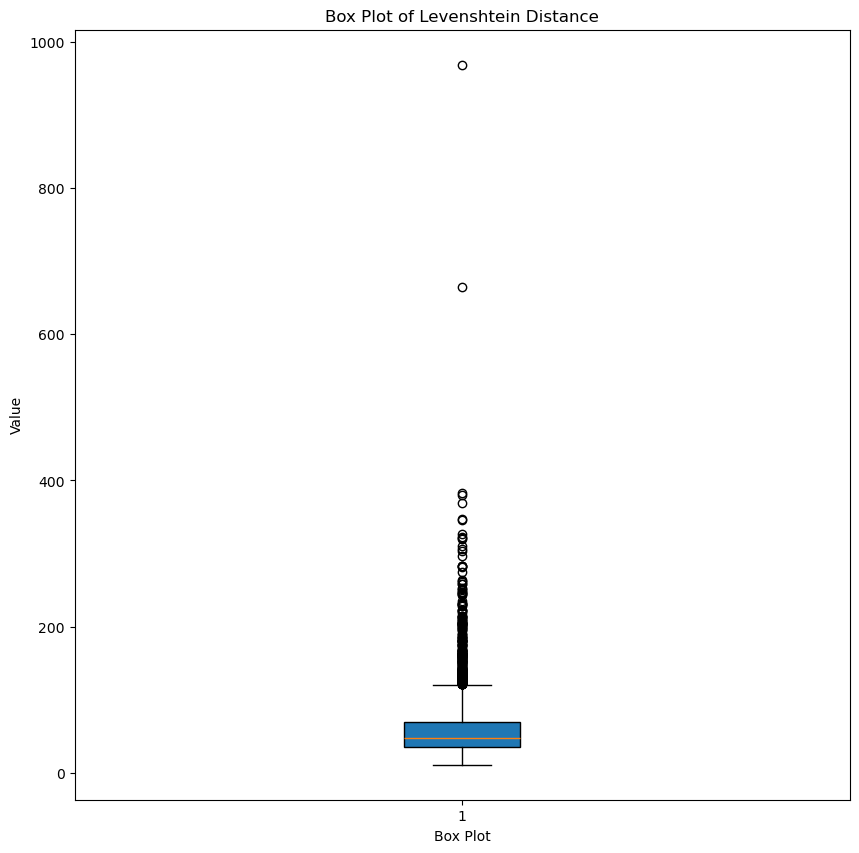

In [8]:
# Plotting boxplot for Levenshtein Distance
plt.figure(figsize=(10, 10))
plt.boxplot(texts['levenshtein_distance'], vert=True, patch_artist=True)

plt.xlabel('Box Plot')
plt.ylabel('Value')
plt.title('Box Plot of Levenshtein Distance')

# Display the plot
plt.show()


In [9]:
# Compute quantiles for Levenshtein distance
quantiles = texts['levenshtein_distance'].quantile([0.80, 0.85, 0.90, 0.95])
quantiles

0.80     75.00
0.85     85.00
0.90     98.10
0.95    125.05
Name: levenshtein_distance, dtype: float64

In [10]:
# After manual checks, we decided to drop recordings with distance <= 125.0
texts = texts[texts['levenshtein_distance'] <= 125.0]

In [11]:
# Now let's drop our R text, we used it before in Toloka to reduce the number of 'cheaters'
texts = texts[texts['INPUT:audio'] != 'https://storage.yandexcloud.net/toloka-chebotarev/TextR_1.0.wav']
texts.reset_index(drop=True, inplace = True)
texts

,INPUT:audio,INPUT:image,OUTPUT:recording,OUTPUT:result_3d_question,OUTPUT:result_1st_question,OUTPUT:result_2nd_question,OUTPUT:result_4th_question,ASSIGNMENT:assignment_id,ASSIGNMENT:worker_id,speechkit_path,file_path,duration,new_path,new_speechkit_path,assigned_text,transcribed_text,levenshtein_distance
0,https://storage.yandexcloud.net/toloka-chebota...,https://storage.yandexcloud.net/toloka-chebota...,eu.c334a2ee-536d-43a3-8f67-972fb9d50d7a,Yes,Yes,No,No,00028edf7c--6613ead849336b29782c831c,6a77f4ba1d04551c0c776dbd7b38e2f5,/Users/grigorijcebotarev/Desktop/thesis/Record...,/Users/grigorijcebotarev/Desktop/thesis/Record...,36.880,/Users/grigorijcebotarev/Desktop/thesis/Record...,/Users/grigorijcebotarev/Desktop/thesis/Record...,3,London is a famous and if her historical city ...,88.0
1,https://storage.yandexcloud.net/toloka-chebota...,https://storage.yandexcloud.net/toloka-chebota...,eu.e0508876-bb3a-4de0-a8ce-c222dd87f1ba,No,No,Yes,Yes,00028edf7c--6613eb144e5be33a301bfdde,f91d95a62d1c07da5f4ddae20e7e6b14,/Users/grigorijcebotarev/Desktop/thesis/Record...,/Users/grigorijcebotarev/Desktop/thesis/Record...,31.940,/Users/grigorijcebotarev/Desktop/thesis/Record...,/Users/grigorijcebotarev/Desktop/thesis/Record...,3,London is a famous and historic city it is the...,31.0
2,https://storage.yandexcloud.net/toloka-chebota...,https://storage.yandexcloud.net/toloka-chebota...,eu.5460ed4b-0053-4ce6-8a99-c46513a685b6,No,No,Yes,Yes,00028edf7c--6613eb8becfe467e31a1cc7f,d1d909f008d9a473e321c469b09888f6,/Users/grigorijcebotarev/Desktop/thesis/Record...,/Users/grigorijcebotarev/Desktop/thesis/Record...,27.460,/Users/grigorijcebotarev/Desktop/thesis/Record...,/Users/grigorijcebotarev/Desktop/thesis/Record...,3,London is a famous and historic city it is the...,32.0
3,https://storage.yandexcloud.net/toloka-chebota...,https://storage.yandexcloud.net/toloka-chebota...,eu.c8e4cec3-f66d-4b83-85a0-e53f29555806,No,Yes,Yes,No,00028edf7c--6613ebbcde86a15063762b27,c747c9be99608de9fba149f76ace19ac,/Users/grigorijcebotarev/Desktop/thesis/Record...,/Users/grigorijcebotarev/Desktop/thesis/Record...,26.944,/Users/grigorijcebotarev/Desktop/thesis/Record...,/Users/grigorijcebotarev/Desktop/thesis/Record...,3,London is a famous historic city it is a capit...,52.0
4,https://storage.yandexcloud.net/toloka-chebota...,https://storage.yandexcloud.net/toloka-chebota...,eu.6de6adc3-809a-4d12-bc7f-caefbbeb81bd,No,Yes,Yes,No,00028edf7c--6613ebf3de86a150637630f1,d3659adf94cc79eb198eac6d53614d1e,/Users/grigorijcebotarev/Desktop/thesis/Record...,/Users/grigorijcebotarev/Desktop/thesis/Record...,26.368,/Users/grigorijcebotarev/Desktop/thesis/Record...,/Users/grigorijcebotarev/Desktop/thesis/Record...,3,No 1 is famous and historic city it is the cap...,90.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3723,https://storage.yandexcloud.net/toloka-chebota...,https://storage.yandexcloud.net/toloka-chebota...,eu.7fcdde19-4b38-4a44-8dc7-a0c68ebb2d06,No,No,Yes,Yes,00028ffbe7--664f07bb42ac8f441d6bf968,542fa70be325c67d6dbf1e376d74e32e,/Users/grigorijcebotarev/Desktop/thesis/Record...,/Users/grigorijcebotarev/Desktop/thesis/Record...,31.659,/Users/grigorijcebotarev/Desktop/thesis/Record...,/Users/grigorijcebotarev/Desktop/thesis/Record...,1,When she was a child jennifer liked sports and...,34.0
3724,https://storage.yandexcloud.net/toloka-chebota...,https://storage.yandexcloud.net/toloka-chebota...,eu.3569cba1-8e98-475a-84fe-971b0dc4c7e9,No,Yes,Yes,Yes,00028ffbe7--664f3cb542ac8f441d6f43be,4c8d438e586e0fec1b8ec7892d810e81,/Users/grigorijcebotarev/Desktop/thesis/Record...,/Users/grigorijcebotarev/Desktop/thesis/Record...,40.520,/Users/grigorijcebotarev/Desktop/thesis/Record...,/Users/grigorijcebotarev/Desktop/thesis/Record...,1,When she was a generic jennifer likes sports a...,105.0
3725,https://storage.yandexcloud.net/toloka-chebota...,https://storage.yandexcloud.net/toloka-chebota...,eu.2b5ec51b-70d7-4031-b831-afe54060cc27,No,No,Yes,Yes,00028ffbe7--664f4f6cdb

### Processing the comfortable speed labels (our target variable)

We will try to combinations of these answers that can show the comfortability of the listener to the given speech:

1. Was this audio recording the most pleasant to listen to? Yes/no/none of above
2. Was the recording understandable? Yes/no
3. Do you think the recording should sound more comfortable if it were slower? yes/no/none of above
4. Do you think that the recording sound more comfortable if it were faster? yes/no/none of above

These are some combinations:
- 1. Yes, 2. Yes, 3. No or None of the above, 4. No or None of the above: <br /> 
This combination suggests that the person found the recording pleasant and understandable, and they did not feel that changing the speed in either direction would make it more comfortable to listen to. This implies that the current speed of the recording was comfortable for the listener.
- 1. No, 2. Yes, 3. No or None of the above, 4. No or None of the above <br /> 
Here, the listener found the recording understandable and did not want the speed changed, even though they did not consider it the most pleasant.
- 1. None of the above, 2. Yes, 3. No or None of the above, 4. No or None of the above <br /> 
This response indicates the recording was understandable, and the listener was comfortable with the speed, although they did not explicitly state if it was pleasant or not.

In [12]:
for index, row in texts.iterrows():
    current_speed = float(row['INPUT:audio'][56:59])
    if (row['OUTPUT:result_1st_question'] == 'Yes' and 
        row['OUTPUT:result_2nd_question'] == 'Yes' and 
       (row['OUTPUT:result_3d_question'] == 'No' or row['OUTPUT:result_3d_question'] == 'None of the above') and 
        (row['OUTPUT:result_4th_question'] == 'No' or row['OUTPUT:result_4th_question'] == 'None of the above')):
        texts.loc[index, 'target_speed'] = current_speed
    elif(row['OUTPUT:result_1st_question'] == 'No' and 
            row['OUTPUT:result_2nd_question'] == 'Yes' and 
            (row['OUTPUT:result_3d_question'] == 'No'  or row['OUTPUT:result_3d_question'] == 'None of the above') and 
            (row['OUTPUT:result_4th_question'] == 'No' or row['OUTPUT:result_4th_question'] == 'None of the above')):
        texts.loc[index, 'target_speed'] = current_speed
    elif(row['OUTPUT:result_1st_question'] == 'None of the above' and 
            row['OUTPUT:result_2nd_question'] == 'Yes' and 
            (row['OUTPUT:result_3d_question'] == 'No'  or row['OUTPUT:result_3d_question'] == 'None of the above') and 
            (row['OUTPUT:result_4th_question'] == 'No' or row['OUTPUT:result_4th_question'] == 'None of the above')):
        texts.loc[index, 'target_speed'] = current_speed

In [13]:
# Grouping by worker_id and computing mean speed value for each toloker
texts.sort_values('ASSIGNMENT:worker_id', inplace=True)
texts['target_speed'] = texts.groupby('ASSIGNMENT:worker_id')['target_speed'].transform('mean')
texts.sort_index(inplace = True)

In [14]:
texts['target_speed'] = texts['target_speed'].round(1)

In [15]:
texts['target_speed'].unique()

array([nan, 0.8, 1.5, 1.2, 0.9, 1. , 0.5, 0.7, 1.1, 0.6, 1.4, 1.3])

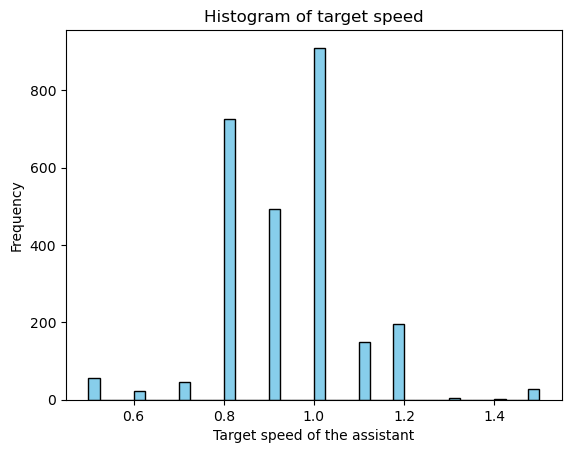

In [16]:
# Plotting histogram of desired speed based on the responses of the tolokers
plt.hist(texts['target_speed'], bins=40, color='skyblue', edgecolor='black')
plt.xlabel('Target speed of the assistant')
plt.ylabel('Frequency')
plt.title('Histogram of target speed')

# Display the plot
plt.show()


In [17]:
def extract_features(file_path, name):
    audio_data, sr = librosa.load(file_path)
    
    # Extract features
    mfcc = pd.DataFrame(librosa.feature.mfcc(y=audio_data, n_mfcc=13, sr=sr)).T
    mfcc.columns = [name + f'mfcc_{i}' for i in range(1, 14)]

    delta_mfccs = pd.DataFrame(librosa.feature.delta(mfcc))
    delta_mfccs.columns = [name + f'delta_mfcc_{i}' for i in range(1, 14)]

    delta2_mfccs = pd.DataFrame(librosa.feature.delta(mfcc, order=2))
    delta2_mfccs.columns = [name + f'delta2_mfcc_{i}' for i in range(1, 14)]

    spectral_centroid = pd.DataFrame(librosa.feature.spectral_centroid(y=audio_data, sr=sr)).T
    spectral_centroid.columns = [name + 'spectral_centroid']

    spectral_rolloff = pd.DataFrame(librosa.feature.spectral_rolloff(y=audio_data, sr=sr)).T
    spectral_rolloff.columns = [name + 'spectral_rolloff']

    spectral_bandwidth = pd.DataFrame(librosa.feature.spectral_bandwidth(y = audio_data, sr=sr)).T
    spectral_bandwidth.columns = [name + 'spectral_bandwidth']

    zcr = pd.DataFrame(librosa.feature.zero_crossing_rate(y=audio_data)).T
    zcr.columns = [name + 'zcr']

    chroma = pd.DataFrame(librosa.feature.chroma_cens(y=audio_data, sr=sr)).T
    chroma.columns = [name + f'chroma_{i}' for i in range(1, 13)]
    df = pd.concat([mfcc.T, delta_mfccs.T, delta2_mfccs.T, spectral_centroid.T, spectral_rolloff.T, spectral_bandwidth.T, zcr.T, chroma.T], 
                   axis = 0)
    return df

In [18]:
#Check if values in the dataframes are close to 0
tolerance = 1e-8
def has_no_zero_values(df, tol=tolerance):
    return not np.any(np.isclose(df.values, 0.0, atol=tol))

In [19]:
# Extracting all features for speechkit and human recordings and save them in one list
all_features = []
for index, row in texts.iterrows():
    features_df = extract_features(row['new_path'], "recording_")
    features_speechkit_df = extract_features(row['new_speechkit_path'], "speechkit_")
    features = pd.concat([features_df, features_speechkit_df]).T
    features['levenshtein_distance'] = row['levenshtein_distance']
    features['duration'] = row['duration']
    features['user_id'] = row['ASSIGNMENT:worker_id']
    features['target_speed'] = row['target_speed']
    all_features.append(features)
    # To check what index is currently processed
    if (index % 100 == 0):
        print(index)

/var/folders/19/c1p_mvln6fx6yqh1573217q00000gn/T/ipykernel_97535/1034549355.py:2: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_data, sr = librosa.load(file_path)
/opt/anaconda3/lib/python3.11/site-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


0


/var/folders/19/c1p_mvln6fx6yqh1573217q00000gn/T/ipykernel_97535/1034549355.py:2: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_data, sr = librosa.load(file_path)
/opt/anaconda3/lib/python3.11/site-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/19/c1p_mvln6fx6yqh1573217q00000gn/T/ipykernel_97535/1034549355.py:2: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_data, sr = librosa.load(file_path)
/opt/anaconda3/lib/python3.11/site-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/19/c1p_mvln6fx6yqh1573217q00000gn/T/ipykernel_97535/1034549355.py:2: User

100


/var/folders/19/c1p_mvln6fx6yqh1573217q00000gn/T/ipykernel_97535/1034549355.py:2: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_data, sr = librosa.load(file_path)
/opt/anaconda3/lib/python3.11/site-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/19/c1p_mvln6fx6yqh1573217q00000gn/T/ipykernel_97535/1034549355.py:2: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_data, sr = librosa.load(file_path)
/opt/anaconda3/lib/python3.11/site-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/19/c1p_mvln6fx6yqh1573217q00000gn/T/ipykernel_97535/1034549355.py:2: User

200


/var/folders/19/c1p_mvln6fx6yqh1573217q00000gn/T/ipykernel_97535/1034549355.py:2: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_data, sr = librosa.load(file_path)
/opt/anaconda3/lib/python3.11/site-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/19/c1p_mvln6fx6yqh1573217q00000gn/T/ipykernel_97535/1034549355.py:2: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_data, sr = librosa.load(file_path)
/opt/anaconda3/lib/python3.11/site-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/19/c1p_mvln6fx6yqh1573217q00000gn/T/ipykernel_97535/1034549355.py:2: User

300


/var/folders/19/c1p_mvln6fx6yqh1573217q00000gn/T/ipykernel_97535/1034549355.py:2: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_data, sr = librosa.load(file_path)
/opt/anaconda3/lib/python3.11/site-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/19/c1p_mvln6fx6yqh1573217q00000gn/T/ipykernel_97535/1034549355.py:2: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_data, sr = librosa.load(file_path)
/opt/anaconda3/lib/python3.11/site-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/19/c1p_mvln6fx6yqh1573217q00000gn/T/ipykernel_97535/1034549355.py:2: User

400


/var/folders/19/c1p_mvln6fx6yqh1573217q00000gn/T/ipykernel_97535/1034549355.py:2: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_data, sr = librosa.load(file_path)
/opt/anaconda3/lib/python3.11/site-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/19/c1p_mvln6fx6yqh1573217q00000gn/T/ipykernel_97535/1034549355.py:2: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_data, sr = librosa.load(file_path)
/opt/anaconda3/lib/python3.11/site-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/19/c1p_mvln6fx6yqh1573217q00000gn/T/ipykernel_97535/1034549355.py:2: User

500


/var/folders/19/c1p_mvln6fx6yqh1573217q00000gn/T/ipykernel_97535/1034549355.py:2: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_data, sr = librosa.load(file_path)
/opt/anaconda3/lib/python3.11/site-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/19/c1p_mvln6fx6yqh1573217q00000gn/T/ipykernel_97535/1034549355.py:2: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_data, sr = librosa.load(file_path)
/opt/anaconda3/lib/python3.11/site-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/19/c1p_mvln6fx6yqh1573217q00000gn/T/ipykernel_97535/1034549355.py:2: User

600


/var/folders/19/c1p_mvln6fx6yqh1573217q00000gn/T/ipykernel_97535/1034549355.py:2: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_data, sr = librosa.load(file_path)
/opt/anaconda3/lib/python3.11/site-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/19/c1p_mvln6fx6yqh1573217q00000gn/T/ipykernel_97535/1034549355.py:2: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_data, sr = librosa.load(file_path)
/opt/anaconda3/lib/python3.11/site-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/19/c1p_mvln6fx6yqh1573217q00000gn/T/ipykernel_97535/1034549355.py:2: User

700


/var/folders/19/c1p_mvln6fx6yqh1573217q00000gn/T/ipykernel_97535/1034549355.py:2: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_data, sr = librosa.load(file_path)
/opt/anaconda3/lib/python3.11/site-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/19/c1p_mvln6fx6yqh1573217q00000gn/T/ipykernel_97535/1034549355.py:2: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_data, sr = librosa.load(file_path)
/opt/anaconda3/lib/python3.11/site-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/19/c1p_mvln6fx6yqh1573217q00000gn/T/ipykernel_97535/1034549355.py:2: User

800


/var/folders/19/c1p_mvln6fx6yqh1573217q00000gn/T/ipykernel_97535/1034549355.py:2: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_data, sr = librosa.load(file_path)
/opt/anaconda3/lib/python3.11/site-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/19/c1p_mvln6fx6yqh1573217q00000gn/T/ipykernel_97535/1034549355.py:2: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_data, sr = librosa.load(file_path)
/opt/anaconda3/lib/python3.11/site-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/19/c1p_mvln6fx6yqh1573217q00000gn/T/ipykernel_97535/1034549355.py:2: User

900


/var/folders/19/c1p_mvln6fx6yqh1573217q00000gn/T/ipykernel_97535/1034549355.py:2: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_data, sr = librosa.load(file_path)
/opt/anaconda3/lib/python3.11/site-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/19/c1p_mvln6fx6yqh1573217q00000gn/T/ipykernel_97535/1034549355.py:2: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_data, sr = librosa.load(file_path)
/opt/anaconda3/lib/python3.11/site-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/19/c1p_mvln6fx6yqh1573217q00000gn/T/ipykernel_97535/1034549355.py:2: User

1000


/var/folders/19/c1p_mvln6fx6yqh1573217q00000gn/T/ipykernel_97535/1034549355.py:2: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_data, sr = librosa.load(file_path)
/opt/anaconda3/lib/python3.11/site-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/19/c1p_mvln6fx6yqh1573217q00000gn/T/ipykernel_97535/1034549355.py:2: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_data, sr = librosa.load(file_path)
/opt/anaconda3/lib/python3.11/site-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/19/c1p_mvln6fx6yqh1573217q00000gn/T/ipykernel_97535/1034549355.py:2: User

1100


/var/folders/19/c1p_mvln6fx6yqh1573217q00000gn/T/ipykernel_97535/1034549355.py:2: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_data, sr = librosa.load(file_path)
/opt/anaconda3/lib/python3.11/site-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/19/c1p_mvln6fx6yqh1573217q00000gn/T/ipykernel_97535/1034549355.py:2: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_data, sr = librosa.load(file_path)
/opt/anaconda3/lib/python3.11/site-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/19/c1p_mvln6fx6yqh1573217q00000gn/T/ipykernel_97535/1034549355.py:2: User

1200


/var/folders/19/c1p_mvln6fx6yqh1573217q00000gn/T/ipykernel_97535/1034549355.py:2: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_data, sr = librosa.load(file_path)
/opt/anaconda3/lib/python3.11/site-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/19/c1p_mvln6fx6yqh1573217q00000gn/T/ipykernel_97535/1034549355.py:2: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_data, sr = librosa.load(file_path)
/opt/anaconda3/lib/python3.11/site-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/19/c1p_mvln6fx6yqh1573217q00000gn/T/ipykernel_97535/1034549355.py:2: User

1300


/var/folders/19/c1p_mvln6fx6yqh1573217q00000gn/T/ipykernel_97535/1034549355.py:2: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_data, sr = librosa.load(file_path)
/opt/anaconda3/lib/python3.11/site-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/19/c1p_mvln6fx6yqh1573217q00000gn/T/ipykernel_97535/1034549355.py:2: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_data, sr = librosa.load(file_path)
/opt/anaconda3/lib/python3.11/site-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/19/c1p_mvln6fx6yqh1573217q00000gn/T/ipykernel_97535/1034549355.py:2: User

1400


/var/folders/19/c1p_mvln6fx6yqh1573217q00000gn/T/ipykernel_97535/1034549355.py:2: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_data, sr = librosa.load(file_path)
/opt/anaconda3/lib/python3.11/site-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/19/c1p_mvln6fx6yqh1573217q00000gn/T/ipykernel_97535/1034549355.py:2: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_data, sr = librosa.load(file_path)
/opt/anaconda3/lib/python3.11/site-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/19/c1p_mvln6fx6yqh1573217q00000gn/T/ipykernel_97535/1034549355.py:2: User

1500


/var/folders/19/c1p_mvln6fx6yqh1573217q00000gn/T/ipykernel_97535/1034549355.py:2: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_data, sr = librosa.load(file_path)
/opt/anaconda3/lib/python3.11/site-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/19/c1p_mvln6fx6yqh1573217q00000gn/T/ipykernel_97535/1034549355.py:2: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_data, sr = librosa.load(file_path)
/opt/anaconda3/lib/python3.11/site-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/19/c1p_mvln6fx6yqh1573217q00000gn/T/ipykernel_97535/1034549355.py:2: User

1600


/var/folders/19/c1p_mvln6fx6yqh1573217q00000gn/T/ipykernel_97535/1034549355.py:2: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_data, sr = librosa.load(file_path)
/opt/anaconda3/lib/python3.11/site-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/19/c1p_mvln6fx6yqh1573217q00000gn/T/ipykernel_97535/1034549355.py:2: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_data, sr = librosa.load(file_path)
/opt/anaconda3/lib/python3.11/site-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/19/c1p_mvln6fx6yqh1573217q00000gn/T/ipykernel_97535/1034549355.py:2: User

1700


/var/folders/19/c1p_mvln6fx6yqh1573217q00000gn/T/ipykernel_97535/1034549355.py:2: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_data, sr = librosa.load(file_path)
/opt/anaconda3/lib/python3.11/site-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/19/c1p_mvln6fx6yqh1573217q00000gn/T/ipykernel_97535/1034549355.py:2: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_data, sr = librosa.load(file_path)
/opt/anaconda3/lib/python3.11/site-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/19/c1p_mvln6fx6yqh1573217q00000gn/T/ipykernel_97535/1034549355.py:2: User

1800


/var/folders/19/c1p_mvln6fx6yqh1573217q00000gn/T/ipykernel_97535/1034549355.py:2: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_data, sr = librosa.load(file_path)
/opt/anaconda3/lib/python3.11/site-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/19/c1p_mvln6fx6yqh1573217q00000gn/T/ipykernel_97535/1034549355.py:2: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_data, sr = librosa.load(file_path)
/opt/anaconda3/lib/python3.11/site-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/19/c1p_mvln6fx6yqh1573217q00000gn/T/ipykernel_97535/1034549355.py:2: User

1900


/var/folders/19/c1p_mvln6fx6yqh1573217q00000gn/T/ipykernel_97535/1034549355.py:2: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_data, sr = librosa.load(file_path)
/opt/anaconda3/lib/python3.11/site-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/19/c1p_mvln6fx6yqh1573217q00000gn/T/ipykernel_97535/1034549355.py:2: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_data, sr = librosa.load(file_path)
/opt/anaconda3/lib/python3.11/site-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/19/c1p_mvln6fx6yqh1573217q00000gn/T/ipykernel_97535/1034549355.py:2: User

2000


/var/folders/19/c1p_mvln6fx6yqh1573217q00000gn/T/ipykernel_97535/1034549355.py:2: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_data, sr = librosa.load(file_path)
/opt/anaconda3/lib/python3.11/site-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/19/c1p_mvln6fx6yqh1573217q00000gn/T/ipykernel_97535/1034549355.py:2: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_data, sr = librosa.load(file_path)
/opt/anaconda3/lib/python3.11/site-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/19/c1p_mvln6fx6yqh1573217q00000gn/T/ipykernel_97535/1034549355.py:2: User

2100


/var/folders/19/c1p_mvln6fx6yqh1573217q00000gn/T/ipykernel_97535/1034549355.py:2: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_data, sr = librosa.load(file_path)
/opt/anaconda3/lib/python3.11/site-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/19/c1p_mvln6fx6yqh1573217q00000gn/T/ipykernel_97535/1034549355.py:2: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_data, sr = librosa.load(file_path)
/opt/anaconda3/lib/python3.11/site-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/19/c1p_mvln6fx6yqh1573217q00000gn/T/ipykernel_97535/1034549355.py:2: User

2200


/var/folders/19/c1p_mvln6fx6yqh1573217q00000gn/T/ipykernel_97535/1034549355.py:2: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_data, sr = librosa.load(file_path)
/opt/anaconda3/lib/python3.11/site-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/19/c1p_mvln6fx6yqh1573217q00000gn/T/ipykernel_97535/1034549355.py:2: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_data, sr = librosa.load(file_path)
/opt/anaconda3/lib/python3.11/site-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/19/c1p_mvln6fx6yqh1573217q00000gn/T/ipykernel_97535/1034549355.py:2: User

2300


/var/folders/19/c1p_mvln6fx6yqh1573217q00000gn/T/ipykernel_97535/1034549355.py:2: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_data, sr = librosa.load(file_path)
/opt/anaconda3/lib/python3.11/site-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/19/c1p_mvln6fx6yqh1573217q00000gn/T/ipykernel_97535/1034549355.py:2: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_data, sr = librosa.load(file_path)
/opt/anaconda3/lib/python3.11/site-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/19/c1p_mvln6fx6yqh1573217q00000gn/T/ipykernel_97535/1034549355.py:2: User

2400


/var/folders/19/c1p_mvln6fx6yqh1573217q00000gn/T/ipykernel_97535/1034549355.py:2: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_data, sr = librosa.load(file_path)
/opt/anaconda3/lib/python3.11/site-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/19/c1p_mvln6fx6yqh1573217q00000gn/T/ipykernel_97535/1034549355.py:2: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_data, sr = librosa.load(file_path)
/opt/anaconda3/lib/python3.11/site-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/19/c1p_mvln6fx6yqh1573217q00000gn/T/ipykernel_97535/1034549355.py:2: User

2500


/var/folders/19/c1p_mvln6fx6yqh1573217q00000gn/T/ipykernel_97535/1034549355.py:2: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_data, sr = librosa.load(file_path)
/opt/anaconda3/lib/python3.11/site-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/19/c1p_mvln6fx6yqh1573217q00000gn/T/ipykernel_97535/1034549355.py:2: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_data, sr = librosa.load(file_path)
/opt/anaconda3/lib/python3.11/site-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/19/c1p_mvln6fx6yqh1573217q00000gn/T/ipykernel_97535/1034549355.py:2: User

2600


/var/folders/19/c1p_mvln6fx6yqh1573217q00000gn/T/ipykernel_97535/1034549355.py:2: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_data, sr = librosa.load(file_path)
/opt/anaconda3/lib/python3.11/site-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/19/c1p_mvln6fx6yqh1573217q00000gn/T/ipykernel_97535/1034549355.py:2: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_data, sr = librosa.load(file_path)
/opt/anaconda3/lib/python3.11/site-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/19/c1p_mvln6fx6yqh1573217q00000gn/T/ipykernel_97535/1034549355.py:2: User

2700


/var/folders/19/c1p_mvln6fx6yqh1573217q00000gn/T/ipykernel_97535/1034549355.py:2: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_data, sr = librosa.load(file_path)
/opt/anaconda3/lib/python3.11/site-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/19/c1p_mvln6fx6yqh1573217q00000gn/T/ipykernel_97535/1034549355.py:2: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_data, sr = librosa.load(file_path)
/opt/anaconda3/lib/python3.11/site-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/19/c1p_mvln6fx6yqh1573217q00000gn/T/ipykernel_97535/1034549355.py:2: User

2800


/var/folders/19/c1p_mvln6fx6yqh1573217q00000gn/T/ipykernel_97535/1034549355.py:2: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_data, sr = librosa.load(file_path)
/opt/anaconda3/lib/python3.11/site-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/19/c1p_mvln6fx6yqh1573217q00000gn/T/ipykernel_97535/1034549355.py:2: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_data, sr = librosa.load(file_path)
/opt/anaconda3/lib/python3.11/site-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/19/c1p_mvln6fx6yqh1573217q00000gn/T/ipykernel_97535/1034549355.py:2: User

2900


/var/folders/19/c1p_mvln6fx6yqh1573217q00000gn/T/ipykernel_97535/1034549355.py:2: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_data, sr = librosa.load(file_path)
/opt/anaconda3/lib/python3.11/site-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/19/c1p_mvln6fx6yqh1573217q00000gn/T/ipykernel_97535/1034549355.py:2: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_data, sr = librosa.load(file_path)
/opt/anaconda3/lib/python3.11/site-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/19/c1p_mvln6fx6yqh1573217q00000gn/T/ipykernel_97535/1034549355.py:2: User

3000


/var/folders/19/c1p_mvln6fx6yqh1573217q00000gn/T/ipykernel_97535/1034549355.py:2: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_data, sr = librosa.load(file_path)
/opt/anaconda3/lib/python3.11/site-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/19/c1p_mvln6fx6yqh1573217q00000gn/T/ipykernel_97535/1034549355.py:2: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_data, sr = librosa.load(file_path)
/opt/anaconda3/lib/python3.11/site-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/19/c1p_mvln6fx6yqh1573217q00000gn/T/ipykernel_97535/1034549355.py:2: User

3100


/var/folders/19/c1p_mvln6fx6yqh1573217q00000gn/T/ipykernel_97535/1034549355.py:2: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_data, sr = librosa.load(file_path)
/opt/anaconda3/lib/python3.11/site-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/19/c1p_mvln6fx6yqh1573217q00000gn/T/ipykernel_97535/1034549355.py:2: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_data, sr = librosa.load(file_path)
/opt/anaconda3/lib/python3.11/site-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/19/c1p_mvln6fx6yqh1573217q00000gn/T/ipykernel_97535/1034549355.py:2: User

3200


/var/folders/19/c1p_mvln6fx6yqh1573217q00000gn/T/ipykernel_97535/1034549355.py:2: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_data, sr = librosa.load(file_path)
/opt/anaconda3/lib/python3.11/site-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/19/c1p_mvln6fx6yqh1573217q00000gn/T/ipykernel_97535/1034549355.py:2: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_data, sr = librosa.load(file_path)
/opt/anaconda3/lib/python3.11/site-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/19/c1p_mvln6fx6yqh1573217q00000gn/T/ipykernel_97535/1034549355.py:2: User

3300


/var/folders/19/c1p_mvln6fx6yqh1573217q00000gn/T/ipykernel_97535/1034549355.py:2: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_data, sr = librosa.load(file_path)
/opt/anaconda3/lib/python3.11/site-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/19/c1p_mvln6fx6yqh1573217q00000gn/T/ipykernel_97535/1034549355.py:2: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_data, sr = librosa.load(file_path)
/opt/anaconda3/lib/python3.11/site-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/19/c1p_mvln6fx6yqh1573217q00000gn/T/ipykernel_97535/1034549355.py:2: User

3400


/var/folders/19/c1p_mvln6fx6yqh1573217q00000gn/T/ipykernel_97535/1034549355.py:2: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_data, sr = librosa.load(file_path)
/opt/anaconda3/lib/python3.11/site-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/19/c1p_mvln6fx6yqh1573217q00000gn/T/ipykernel_97535/1034549355.py:2: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_data, sr = librosa.load(file_path)
/opt/anaconda3/lib/python3.11/site-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/19/c1p_mvln6fx6yqh1573217q00000gn/T/ipykernel_97535/1034549355.py:2: User

3500


/var/folders/19/c1p_mvln6fx6yqh1573217q00000gn/T/ipykernel_97535/1034549355.py:2: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_data, sr = librosa.load(file_path)
/opt/anaconda3/lib/python3.11/site-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/19/c1p_mvln6fx6yqh1573217q00000gn/T/ipykernel_97535/1034549355.py:2: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_data, sr = librosa.load(file_path)
/opt/anaconda3/lib/python3.11/site-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/19/c1p_mvln6fx6yqh1573217q00000gn/T/ipykernel_97535/1034549355.py:2: User

3600


/var/folders/19/c1p_mvln6fx6yqh1573217q00000gn/T/ipykernel_97535/1034549355.py:2: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_data, sr = librosa.load(file_path)
/opt/anaconda3/lib/python3.11/site-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/19/c1p_mvln6fx6yqh1573217q00000gn/T/ipykernel_97535/1034549355.py:2: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_data, sr = librosa.load(file_path)
/opt/anaconda3/lib/python3.11/site-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/19/c1p_mvln6fx6yqh1573217q00000gn/T/ipykernel_97535/1034549355.py:2: User

3700


/var/folders/19/c1p_mvln6fx6yqh1573217q00000gn/T/ipykernel_97535/1034549355.py:2: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_data, sr = librosa.load(file_path)
/opt/anaconda3/lib/python3.11/site-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/19/c1p_mvln6fx6yqh1573217q00000gn/T/ipykernel_97535/1034549355.py:2: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_data, sr = librosa.load(file_path)
/opt/anaconda3/lib/python3.11/site-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/var/folders/19/c1p_mvln6fx6yqh1573217q00000gn/T/ipykernel_97535/1034549355.py:2: User

In [20]:
#Splitting the obtained results in two lists - with set and NaN target speed
all_features_speed_null = []
all_features_speed_not_null = []
for df in all_features:
    if (df['target_speed'].isnull().sum() > 0):
        all_features_speed_null.append(df)
    else:
        all_features_speed_not_null.append(df)
        
    
# print(pd.concat(all_features, ignore_index = True).T)

In [21]:
#Let's have a look at the number of available speed and the number of null speed observations
# (where we couldn't choose the speed for the toloker based on his responses)
print(len(all_features_speed_null))
print(len(all_features_speed_not_null))

1093
2635


In [22]:
# Just have a look how each dataframe in the list appears 
all_features_speed_null[39]

,recording_mfcc_1,recording_mfcc_2,recording_mfcc_3,recording_mfcc_4,recording_mfcc_5,recording_mfcc_6,recording_mfcc_7,recording_mfcc_8,recording_mfcc_9,recording_mfcc_10,...,speechkit_chroma_7,speechkit_chroma_8,speechkit_chroma_9,speechkit_chroma_10,speechkit_chroma_11,speechkit_chroma_12,levenshtein_distance,duration,user_id,target_speed
0,-482.259888,44.133186,59.520824,19.483381,32.091480,7.587019,29.913967,2.781484,-6.041524,-0.141640,...,0.301637,0.408422,0.537489,0.460429,0.240247,0.159176,52.0,44.86,0a4bd0f2c244ab02e9dcaff2a92ec127,NaN
1,-383.847717,61.032131,72.514442,25.813213,32.254715,3.084046,27.951828,0.288072,-9.579259,-3.323632,...,0.291026,0.401357,0.544084,0.476960,0.240562,0.152171,52.0,44.86,0a4bd0f2c244ab02e9dcaff2a92ec127,NaN
2,-353.215057,62.112289,74.466782,30.028088,33.634132,2.148104,26.008533,2.782530,-8.157969,0.038007,...,0.280562,0.394392,0.549996,0.492784,0.240325,0.145722,52.0,44.86,0a4bd0f2c244ab02e9dcaff2a92ec127,NaN
3,-357.587830,46.082718,64.436768,21.672947,30.179295,6.498934,27.637939,5.921185,-1.415308,8.510121,...,0.270374,0.387725,0.555180,0.507655,0.239482,0.140104,52.0,44.86,0a4bd0f2c244ab02e9dcaff2a92ec127,NaN
4,-364.760193,29.336777,48.334976,7.989408,19.619598,-5.859752,20.620111,3.334459,1.029019,14.336705,...,0.260500,0.381470,0.559600,0.521381,0.238031,0.135444,52.0,44.86,0a4bd0f2c244ab02e9dcaff2a92ec127,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3822,-379.642242,87.475616,61.973576,37.530258,23.346785,15.066550,15.843483,2.892810,6.623621,10.064575,...,0.109245,0.102857,0.231724,0.387300,0.601714,0.460009,52.0,44.86,0a4bd0f2c244ab02e9dcaff2a92ec127,NaN
3823,-385.037933,85.155579,58.878159,30.331841,26.091974,15.039931,11.202473,3.960711,5.960685,10.920829,...,0.102216,0.107177,0.237898,0.393164,0.601192,0.452391,52.0,44.86,0a4bd0f2c244ab02e9dcaff2a92ec127,NaN
3824,-394.588837,69.323227,41.654961,16.201092,26.414562,9.410862,6.134578,7.305364,10.908783,13.455296,...,0.095809,0.111827,0.243832,0.398499,0.599687,0.445615,52.0,44.86,0a4bd0f2c244ab02e9dcaff2a92ec127,NaN
3825,-398.871490,69.770920,35.476204,14.351693,21.217793,10.453559,6.724494,6.758171,10.862112,8.461308,...,0.090335,0.116914,0.249379,0.403124,0.597304,0.440006,52.0,44.86,0a4bd0f2c244ab02e9dcaff2a92ec127,NaN


In [27]:
import tarfile
# Now let's save the obtained lists of dataframes in the tar archive and 
# proceed to imputing missed speed for the list 'all_features_speed_null'

csv_files = [f'{i}.csv'for i, _ in enumerate(all_features_speed_not_null)]
for df, filename in zip(all_features_speed_not_null, csv_files):
    df.to_csv(filename, index = False)
tar_ = "notnull_features.tar.gz"
with tarfile.open(tar_, 'w:gz') as tar:
    for file in csv_files:
        tar.add(file, arcname = file)
    
    

In [26]:
csv_test_files = [f'{i}.csv'for i, _ in enumerate(all_features_speed_null)]
for df, filename in zip(all_features_speed_null, csv_test_files):
    df.to_csv(filename, index = False)
tar_ = "null_features.tar.gz"
with tarfile.open(tar_, 'w:gz') as tar:
    for file in csv_test_files:
        tar.add(file, arcname = file)

### We have saved our preprocessed texts with features in two tar archives. Now we are ready to move to imputing NaN target speed values in the 'all_features_speed_null' list